In [42]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json
import nltk
import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle

In [43]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [44]:
# Load data
data_train = pd.read_csv('../Data Splits/train_data_60_40.csv')
data_val = pd.read_csv('../Data Splits/val_data_60_40.csv')

In [45]:
X_train = data_train['article']
y_train = data_train['label']

X_val = data_val['article']
y_val = data_val['label']

In [46]:
# Text preprocessing
def remove_diacritics(text):
    normalized = unicodedata.normalize("NFD", text)
    return "".join(c for c in normalized if unicodedata.category(c) != "Mn")

def wordopt(text):
    text = text.lower()
    text = remove_diacritics(text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r"\\W", " ", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

ps = PorterStemmer()
with open('../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)
def preprocess(text):
    text = wordopt(text)
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(token) for token in tokens]
    filtered = [stem for stem in stems if stem not in stopwords]
    return filtered

In [47]:
# Apply preprocess function to X_train
X_train = X_train.apply(preprocess)

# Apply preprocess function to X_val
X_val = X_val.apply(preprocess)

In [48]:
# Convert the preprocessed text into a list of strings
X_train_processed = [' '.join(tokens) for tokens in X_train]
X_val_processed = [' '.join(tokens) for tokens in X_val]

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)

# Transform the validation data using the same vectorizer
X_val_tfidf = tfidf_vectorizer.transform(X_val_processed)

# Print the shape of the TF-IDF matrices (No of rows, No of columns)
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_val_tfidf:", X_val_tfidf.shape)

Shape of X_train_tfidf: (1731, 26336)
Shape of X_val_tfidf: (1154, 26336)


In [49]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

In [50]:
# Define the XGBClassifier as meta learner
mlp = MLPClassifier()

# Define the parameter grid
param_grid = {
            'hidden_layer_sizes': [(10,), (20,), (50,), (100,)], 
            'activation': ['relu', 'tanh', 'logistic'], 
            'solver': ['sgd', 'adam'], 
            'learning_rate': ['constant', 'adaptive']
            }

# Define the GridSearchCV
mlp_grid = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

In [51]:
mlp_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [(10,), (20,), (50,), (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy')

In [52]:
print("Best Hyperparameters: ", mlp_grid.best_params_)
print("Best Accuracy: {:.2f}%".format(mlp_grid.best_score_ * 100))

Best Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}
Best Accuracy: 94.74%


In [53]:
best_meta = mlp_grid.best_estimator_
joblib.dump(best_meta, '../Models/60-40 Test/stackmodel_mlp_best_estimator.joblib')

['../Models/60-40 Test/stackmodel_mlp_best_estimator.joblib']

In [54]:
stack = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta, cv=5)
stack.fit(X_train_tfidf, y_train)

c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('MNB', MultinomialNB()),
                               ('LR', LogisticRegression()),
                               ('RF', RandomForestClassifier()),
                               ('KNN', KNeighborsClassifier()),
                               ('SVM', SVC(probability=True))],
                   final_estimator=MLPClassifier(hidden_layer_sizes=(20,)))

Metrics for MNB:
Accuracy: 0.8509532062391681
Precision: 0.7824267782426778
Recall: 0.9722703639514731
F1 Score: 0.8670788253477589
AUC: 0.9705612908457959
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83       577
           1       0.78      0.97      0.87       577

    accuracy                           0.85      1154
   macro avg       0.87      0.85      0.85      1154
weighted avg       0.87      0.85      0.85      1154



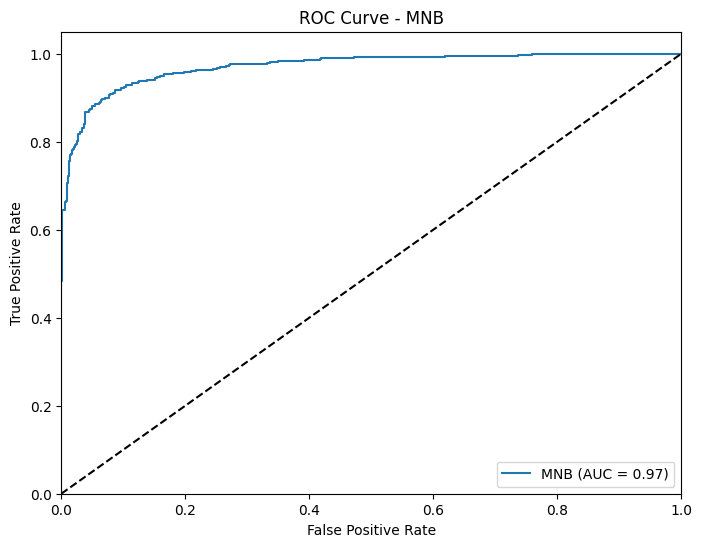

Metrics for LR:
Accuracy: 0.9280762564991335
Precision: 0.9591078066914498
Recall: 0.8942807625649913
F1 Score: 0.9255605381165919
AUC: 0.9834499247587324
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       577
           1       0.96      0.89      0.93       577

    accuracy                           0.93      1154
   macro avg       0.93      0.93      0.93      1154
weighted avg       0.93      0.93      0.93      1154



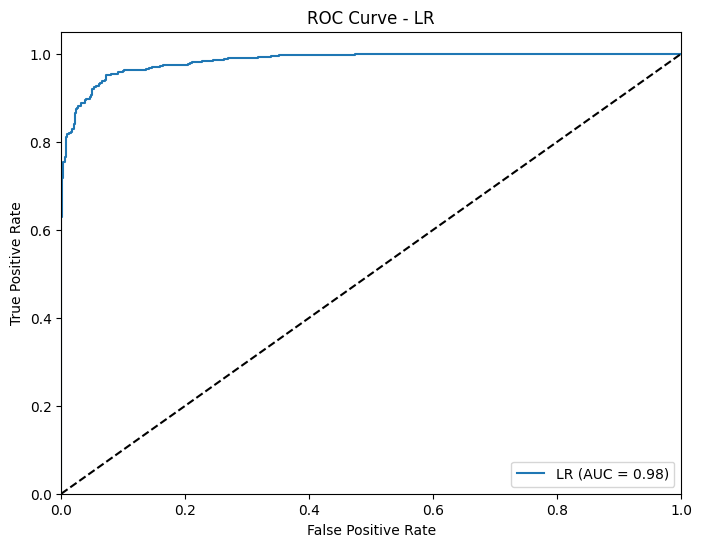

Metrics for RF:
Accuracy: 0.9376083188908145
Precision: 0.9533213644524237
Recall: 0.9202772963604853
F1 Score: 0.9365079365079365
AUC: 0.9843359995674753
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       577
           1       0.95      0.92      0.94       577

    accuracy                           0.94      1154
   macro avg       0.94      0.94      0.94      1154
weighted avg       0.94      0.94      0.94      1154



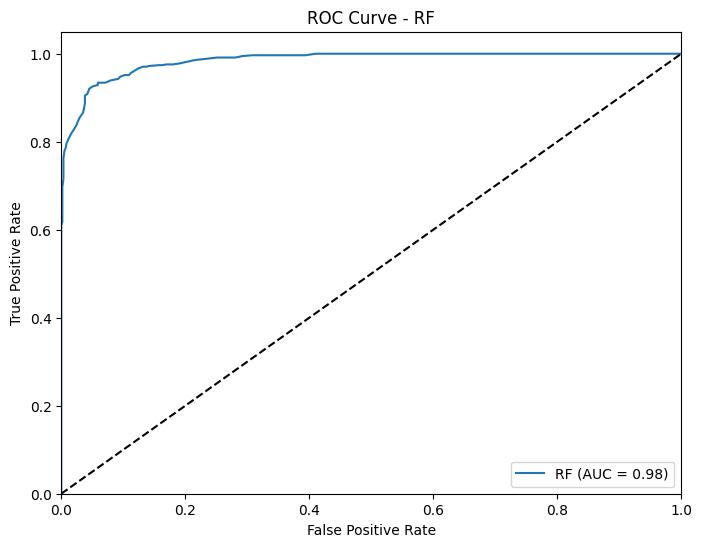

Metrics for KNN:
Accuracy: 0.8552859618717504
Precision: 0.8068862275449101
Recall: 0.9341421143847487
F1 Score: 0.8658634538152611
AUC: 0.9419876309963986
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       577
           1       0.81      0.93      0.87       577

    accuracy                           0.86      1154
   macro avg       0.86      0.86      0.85      1154
weighted avg       0.86      0.86      0.85      1154



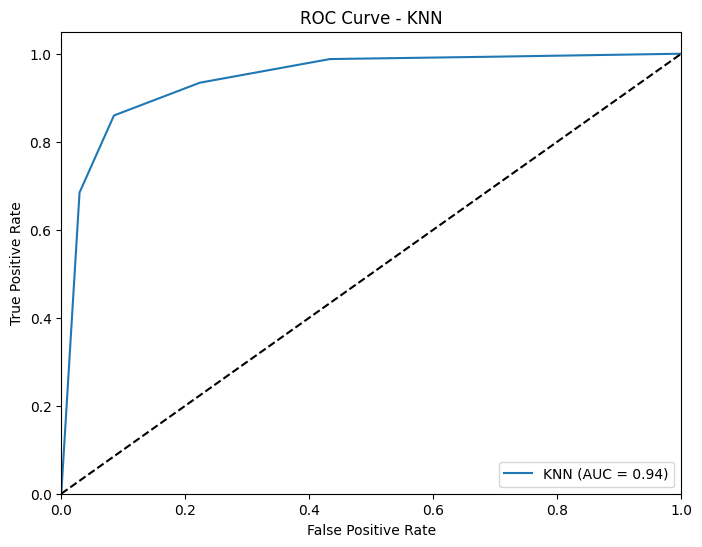

Metrics for SVM:
Accuracy: 0.9428076256499134
Precision: 0.9757914338919925
Recall: 0.9081455805892548
F1 Score: 0.940754039497307
AUC: 0.9880890520201004
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       577
           1       0.98      0.91      0.94       577

    accuracy                           0.94      1154
   macro avg       0.94      0.94      0.94      1154
weighted avg       0.94      0.94      0.94      1154



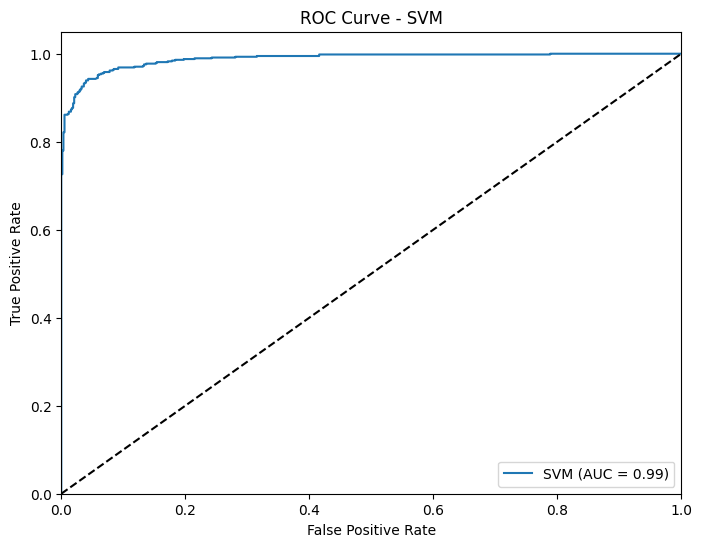

In [55]:
# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])


# Evaluate base models
for model, name in zip(base_models, base_names):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    y_prob = model.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9506065857885615
Precision: 0.9513888888888888
Recall: 0.949740034662045
F1 Score: 0.9505637467476149
AUC: 0.9904123702050588
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       577
           1       0.95      0.95      0.95       577

    accuracy                           0.95      1154
   macro avg       0.95      0.95      0.95      1154
weighted avg       0.95      0.95      0.95      1154



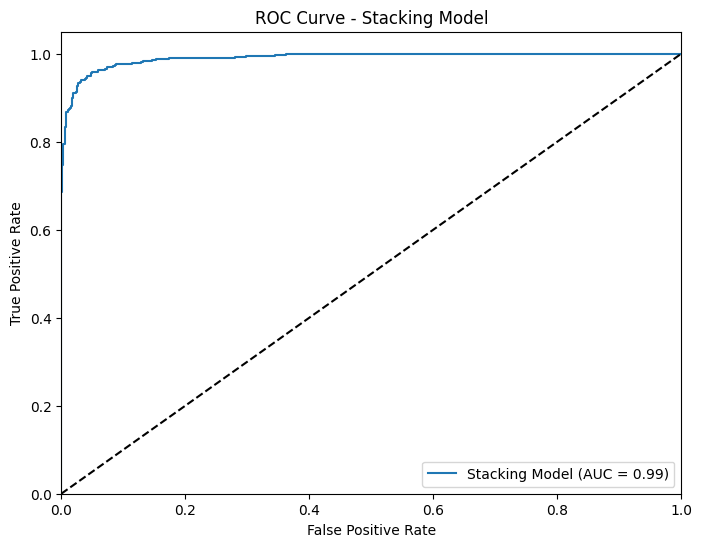

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.850953  0.782427   0.97227  0.867079  0.970561
LR              0.928076  0.959108  0.894281  0.925561   0.98345
RF              0.937608  0.953321  0.920277  0.936508  0.984336
KNN             0.855286  0.806886  0.934142  0.865863  0.941988
SVM             0.942808  0.975791  0.908146  0.940754  0.988089
Stacking Model  0.950607  0.951389   0.94974  0.950564  0.990412


In [56]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val_tfidf)
stack_y_prob = stack.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [57]:
# Save the model using joblib
joblib.dump(stack, '../Models/60-40 Test/stackmodel_mlp.joblib')

['../Models/60-40 Test/stackmodel_mlp.joblib']